In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
# Training data. Failure occurs on the last cycle.
train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)

# Test data. Failure occurs on the last cycle.
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)

# Data from the NASA dataset
Column 0 corresponds to the different engine cycles

Column 1 corresponds to the same engine timestamp until failure occured

Column 2-4 correspond to the settings of the engine

Column 5-27 corresond to the different values we got from sensors located in the engine

In [10]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [14]:
print(train_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

Column 26 and 27 have no values. We will drop those.

In [19]:
train_df = train_df.drop(columns=[26,27])

In [21]:
descriptive_stats = train_df.describe(include='all').T
nan_counts = train_df.isna().sum()
zero_counts = (train_df == 0).sum()
summary_df = pd.DataFrame({
    'mean': descriptive_stats['mean'],
    'std': descriptive_stats['std'],
    'nan_count': nan_counts,
    'zero_count': zero_counts
})


In [22]:
print(summary_df)

           mean           std  nan_count  zero_count
0     51.506568  2.922763e+01          0           0
1    108.807862  6.888099e+01          0           0
2     -0.000009  2.187313e-03          0         413
3      0.000002  2.930621e-04          0        2070
4    100.000000  0.000000e+00          0           0
5    518.670000  0.000000e+00          0           0
6    642.680934  5.000533e-01          0           0
7   1590.523119  6.131150e+00          0           0
8   1408.933782  9.000605e+00          0           0
9     14.620000  1.776400e-15          0           0
10    21.609803  1.388985e-03          0           0
11   553.367711  8.850923e-01          0           0
12  2388.096652  7.098548e-02          0           0
13  9065.242941  2.208288e+01          0           0
14     1.300000  0.000000e+00          0           0
15    47.541168  2.670874e-01          0           0
16   521.413470  7.375534e-01          0           0
17  2388.096152  7.191892e-02          0      

/Users/antonis/miniforge3/envs/py10/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: invalid value encountered in log
  return lib.map_infer(values, mapper, convert=convert)
/Users/antonis/miniforge3/envs/py10/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=convert)


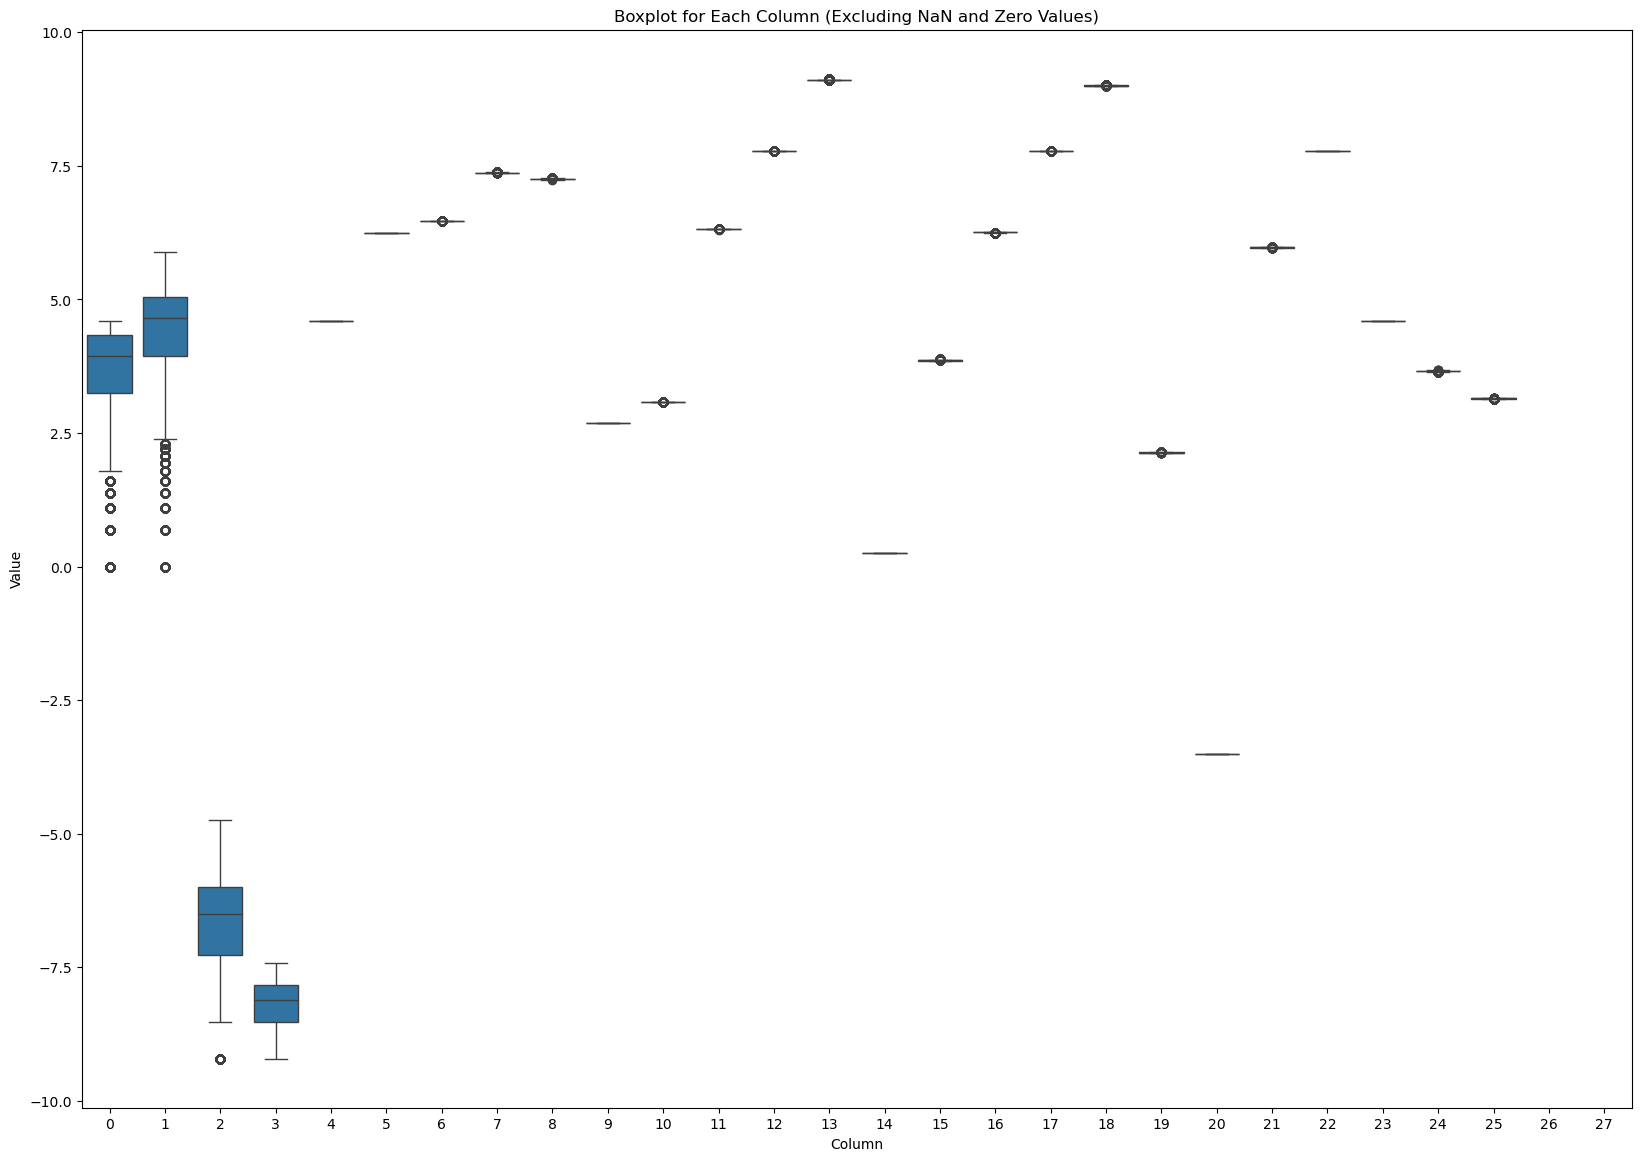

In [35]:
df_log = train_df.map(np.log)

melted_df_cleaned = df_log.melt(var_name='Column', value_name='Value')

plt.figure(figsize=(20, 14))
sns.boxplot(x='Column', y='Value', data=melted_df_cleaned)
plt.title('Boxplot for Each Column (Excluding NaN and Zero Values)')
plt.show()